In [5]:
import torch
import torchvision
import cv2
import os
import numpy as np
import pandas as pd
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.transforms import ToTensor
from deep_sort_realtime.deepsort_tracker import DeepSort
from utils import convert_detections
from coco_classes import COCO_91_CLASSES

experiment = '008' #formatted in 00X style
MODEL_PATH = '/home/rohit/AIXI/model1_8/checkpoints/run_11/model_epoch_17.pth'
IMAGES_FOLDER = f'/home/rohit/AIXI/analysis/data/ma2035_{experiment}/'
OUT_DIR = 'dets_and_tracks'
DETECTIONS_CSV = os.path.join(OUT_DIR, f'detections_{experiment}.csv')
TRACKS_CSV = os.path.join(OUT_DIR, f'tracks_{experiment}.csv')
VIDEO_OUTPUT = f'videos/tracked_{experiment}.mp4'


In [6]:
# Configuration Parameters
IMG_SIZE = None  # Set to 640 for resizing to 640x640, None to use original size
THRESHOLD = 0.8
MODEL_NAME = 'fasterrcnn_resnet50_fpn_v2'
EMBEDDER = 'mobilenet'

# Create output directories
os.makedirs(OUT_DIR, exist_ok=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
np.random.seed(42)

# Load model
model = fasterrcnn_resnet50_fpn(weights="DEFAULT", box_detections_per_img=400)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=2)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.to(device).eval()

# Initialize the Deep SORT tracker
tracker = DeepSort(max_age=30, embedder=EMBEDDER)  # Reduce overlap threshold

# Get image files
image_files = sorted([os.path.join(IMAGES_FOLDER, img) for img in os.listdir(IMAGES_FOLDER) if img.endswith('.jpg')])

# CSV DataFrames
detections_df = pd.DataFrame(columns=['filename', 'xmin', 'ymin', 'xmax', 'ymax', 'class', 'confidence'])
tracks_df = pd.DataFrame(columns=['track_id', 'xmin', 'ymin', 'xmax', 'ymax', 'frame','filename'])

def format_detections_for_csv(detections, threshold, classes):
    results = []
    for det in detections:
        bbox, score, label = det  # Unpack the tuple
        if score >= threshold and str(label) in classes:
            xmin, ymin, w, h = bbox  # Assuming bbox is formatted as [xmin, ymin, width, height]
            xmax = xmin + w
            ymax = ymin + h
            results.append({
                'xmin': xmin,
                'ymin': ymin,
                'xmax': xmax,
                'ymax': ymax,
                'class': label,
                'confidence': score
            })
    return results


for frame_idx, image_path in enumerate(image_files):
    frame = cv2.imread(image_path)
    if frame is None or frame.size == 0:
        print(f"Skipping empty or invalid image at {image_path}")
        continue
    if IMG_SIZE:
        frame = cv2.resize(frame, (IMG_SIZE, IMG_SIZE))
    frame_tensor = ToTensor()(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)).unsqueeze(0).to(device)

    with torch.no_grad():
        detections = model(frame_tensor)[0]

    # Process detections for tracking
    try:
        detections = convert_detections(detections, THRESHOLD, [1])  # Assuming class '1' is of interest
        tracks = tracker.update_tracks(detections, frame=frame)
    except Exception as e:
        print(f"Error processing frame {frame_idx}: {e}")


    formatted_detections = format_detections_for_csv(detections, THRESHOLD, ['1'])

    # Save detections to DataFrame
    for det in formatted_detections:
        new_row = pd.DataFrame([{
            'filename': os.path.basename(image_path),
            'xmin': det['xmin'],
            'ymin': det['ymin'],
            'xmax': det['xmax'],
            'ymax': det['ymax'],
            'class': det['class'],
            'confidence': det['confidence']
        }])
        detections_df = pd.concat([detections_df, new_row], ignore_index=True)

    # Save tracks to DataFrame
    for track in tracks:
        if track.is_confirmed():
            bbox = track.to_tlbr(orig=False)  # Get bounding box in format (min x, min y, max x, max y)
            new_row = pd.DataFrame([{
                'track_id': track.track_id,
                'xmin': bbox[0],
                'ymin': bbox[1],
                'xmax': bbox[2],
                'ymax': bbox[3],
                'frame': frame_idx,
                'filename': os.path.basename(image_path)  # Adding filename for each track
            }])
            tracks_df = pd.concat([tracks_df, new_row], ignore_index=True)

# Save DataFrames to CSV files
detections_df.to_csv(os.path.join(DETECTIONS_CSV), index=False)
tracks_df.to_csv(os.path.join(TRACKS_CSV), index=False)
print("All frames processed. Detection and track results saved.")
print(DETECTIONS_CSV)

/tmp/ipykernel_39392/2076909749.py:82: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  detections_df = pd.concat([detections_df, new_row], ignore_index=True)
/tmp/ipykernel_39392/2076909749.py:97: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tracks_df = pd.concat([tracks_df, new_row], ignore_index=True)


All frames processed. Detection and track results saved.
dets_and_tracks/detections_008.csv


In [7]:
print(DETECTIONS_CSV)

dets_and_tracks/detections_250.csv


Animation saved as videos/tracked_246_nms08.mp4


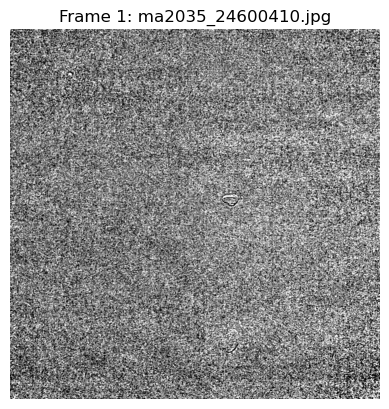

In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.patches as patches
import cv2




# Load track data from CSV
tracks_df = pd.read_csv(TRACKS_CSV)

# Sorting the images
images = sorted([img for img in os.listdir(IMAGES_FOLDER) if img.endswith('.jpg')])

fig, ax = plt.subplots()

def update(frame_idx):
    ax.clear()
    filename = images[frame_idx]
    image_path = os.path.join(IMAGES_FOLDER, filename)

    # Read the image using OpenCV
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB

    # Display the image
    ax.imshow(image)
    ax.set_title(f'Frame {frame_idx + 1}: {filename}')

    # Filter tracks for the current frame and the current image
    current_tracks = tracks_df[(tracks_df['frame'] == frame_idx) & (tracks_df['filename'] == filename)]

    # Plot each track
    for _, track in current_tracks.iterrows():
        xmin, ymin, xmax, ymax = track['xmin'], track['ymin'], track['xmax'], track['ymax']
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(xmin, ymin, f'Track ID: {track["track_id"]}', color='red', fontsize=8)

    plt.axis('off')  # Turn off axis

# Create animation
ani = FuncAnimation(fig, update, frames=len(images), repeat=False)

# Save the animation
ani.save(VIDEO_OUTPUT, writer='ffmpeg', fps=30)

print(f"Animation saved as {VIDEO_OUTPUT}")

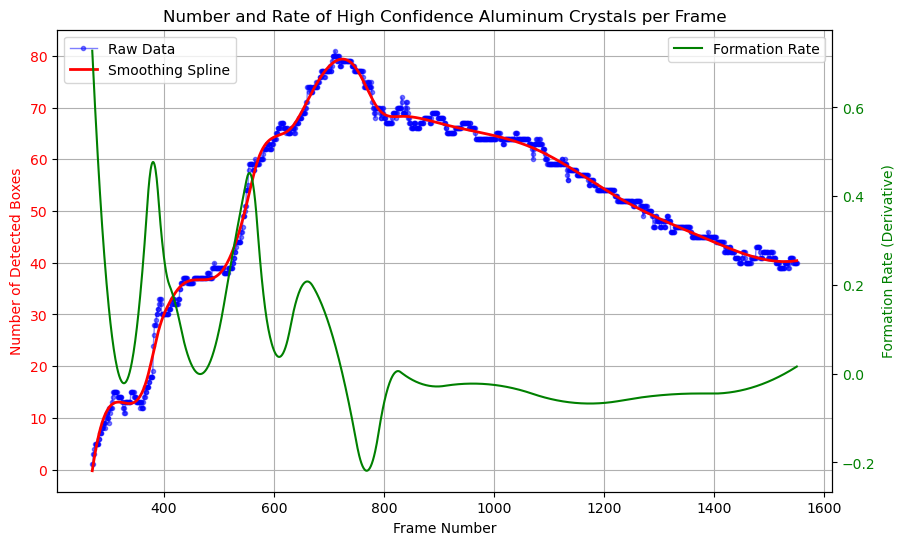

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline

# Load the predictions from CSV
def load_predictions(csv_file):
    return pd.read_csv(csv_file)

# Count the number of boxes per frame with confidence above a specified threshold
def count_boxes_per_frame(predictions,  max_frame):
    predictions['frame'] = predictions['filename'].apply(lambda x: int(x.split('_')[1][3:8]))
    #filtered_predictions = predictions[predictions['confidence'] > confidence_threshold]
    filtered_predictions = predictions
    count_per_frame = filtered_predictions.groupby('frame').size()
    count_per_frame = count_per_frame[count_per_frame.index <= max_frame]
    return count_per_frame

def smooth_derivative(y, x, smoothing_factor):
    """ Calculate a smoothed derivative of y with respect to x using a wide central difference method. """
    # Fit a smoothing spline
    spline = UnivariateSpline(x, y, s=smoothing_factor)
    # Compute the derivative
    dspline = spline.derivative()
    # Evaluate the derivative at the x values
    dy = dspline(x)
    return dy, spline

def plot_data_with_derivative(x, y, dy, spline):
    """ Plot both the original data with smoothing spline and its derivative. """
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot original data and spline
    ax1.plot(x, y, 'o-', markersize=3, alpha=0.5, label='Raw Data', color='blue', linewidth=1)
    ax1.plot(x, spline(x), '-', linewidth=2, label='Smoothing Spline', color='red')
    ax1.set_xlabel('Frame Number')
    ax1.set_ylabel('Number of Detected Boxes', color='red')
    ax1.tick_params(axis='y', labelcolor='red')
    ax1.legend(loc='upper left')
    ax1.grid(True)

    # Create a second y-axis for the derivative
    ax2 = ax1.twinx()
    ax2.plot(x, dy, '-', color='green', label='Formation Rate')
    ax2.set_ylabel('Formation Rate (Derivative)', color='green')
    ax2.tick_params(axis='y', labelcolor='green')
    ax2.legend(loc='upper right')

    plt.title('Number and Rate of High Confidence Aluminum Crystals per Frame')
    plt.show()

# Main execution block
if __name__ == "__main__":
    predictions = load_predictions(TRACKS_CSV)  # ensure to provide the correct path to your CSV file
    count_per_frame = count_boxes_per_frame(predictions, max_frame=1550)
    x = count_per_frame.index.values
    y = count_per_frame.values
    dy, spline_object = smooth_derivative(y, x, smoothing_factor=2000)  # Adjust smoothing factor for your data
    plot_data_with_derivative(x, y, dy, spline_object)
